# Business Impact Analysis

In this section, we are going to investigate the impact of the churn model we built previously, as well as the discount strategy proposed by the business, on order to maximize the revenue.

For this we are going to compare the revenue when no discount is applied, with the revenue when the discount is applied to the customers with a certain churn probability that we will define.

---

## Import Packages, Load Data and Model, Prepare Predictions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier

import joblib

# shows plots in jupyter notebook
%matplotlib inline

# set plot style
sns.set(color_codes=True)

In [10]:
model_df = pd.read_csv('../data/processed/model_data.csv') # data used for training the model and for making predictions
raw_df = pd.read_csv('../data/raw/client_data.csv') # original data to join with predictions

In [16]:
model = joblib.load('../models/random_forest.joblib')
print(type(model))
model

<class 'sklearn.ensemble._forest.RandomForestClassifier'>


RandomForestClassifier(class_weight={0: 1, 1: 7}, max_depth=5,
                       max_features=None, random_state=42)

We have successfully loaded everything we need to start our post analysis. Now we need to work our way with the data for making predictions, but this time, instead of predicting the churn class, we are going to predict the probabilities.

---

## Prepare Predictions

In [11]:
model_df.dtypes

cons_12m                    float64
cons_gas_12m                float64
off_peak_forecast_energy    float64
off_peak_forecast_power     float64
imp_cons                    float64
margin_net_pow_ele          float64
net_margin                  float64
pow_max                     float64
off_peak_mean_energy        float64
off_peak_mean_power         float64
off_peak_diff_energy        float64
off_peak_diff_power         float64
dtype: object

In [14]:
churn_pred_proba = model.predict_proba(model_df)[:,1]
print('Shape of predictions: ', churn_pred_proba.shape)
print(churn_pred_proba[:5])

Shape of predictions:  (14606,)
[0.5330492  0.31563323 0.41813068 0.44546116 0.5333701 ]


Let's add the churn probability to the raw dataframe.

In [17]:
raw_df['churn_pred_proba'] = churn_pred_proba
raw_df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn,churn_pred_proba
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.00,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1,0.533049
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.00,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0,0.315633
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.00,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0,0.418131
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.00,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0,0.445461
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,52.32,44.91,44.91,1,47.98,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,19.800,0,0.533370


We're all set to start our analysis.

---

## Calculate Revenue

We are going to calculate the revenue expected from each client, for both cases: with and without discount.  
We need to take into account the churn and churn probabilities.

- The revenue could be calculated by multiplaying the forecasted energy consumption and forecasted energy price, and we can add the forecasted meter rental price for the next 12 months.
- This consists of a revenue without taking churn into account, so for churned clients, we don't know when they are going to churn exactly (somewhere between january and march of 2016). There are 59 days in which the client can quit, churning at the first day results in a 100% decrease in revenue, and on the last day results in a 83.9% decrease. If we would take the average, we can take the calculated revenue, and reduce it by 91.9%. This would be the final revenue value, for the case of no discount.

In [20]:
raw_df.dtypes

id                                 object
channel_sales                      object
cons_12m                            int64
cons_gas_12m                        int64
cons_last_month                     int64
date_activ                         object
date_end                           object
date_modif_prod                    object
date_renewal                       object
forecast_cons_12m                 float64
forecast_cons_year                  int64
forecast_discount_energy          float64
forecast_meter_rent_12m           float64
forecast_price_energy_off_peak    float64
forecast_price_energy_peak        float64
forecast_price_pow_off_peak       float64
has_gas                            object
imp_cons                          float64
margin_gross_pow_ele              float64
margin_net_pow_ele                float64
nb_prod_act                         int64
net_margin                        float64
num_years_antig                     int64
origin_up                         

In [21]:
raw_df['revenue_raw'] = raw_df['forecast_price_energy_peak'] * raw_df['forecast_cons_12m'] + raw_df['forecast_meter_rent_12m']
raw_df['revenue_no_discount'] = raw_df['revenue_raw'] * (1 - 0.919 * raw_df['churn'])

And let's calculate the revenue for the case of applying the discount. We're interested in the difference in revenue between the two cases, so we'll have a function that calculates this, and takes in the probability threshold for applying the discount as a parameter.  
For this we are going to keep the revenue is it is before discount for clients with low churn probability, and for those with a high chance of churning, we are going to give them the 20% discount, meaning that their raw revenue will be reduced by 20%, since we assume that anyone given this discount will use it.

In [22]:
def revenue_diff(proba=0.5, discount=0.2):
    raw_df['revenue_discount'] = raw_df['revenue_no_discount']
    raw_df.loc[raw_df['churn_pred_proba'] >= proba, 'revenue_discount'] = raw_df['revenue_raw'] * (1 - discount)
    raw_df['revenue_diff'] = raw_df['revenue_discount'] - raw_df['revenue_no_discount']
    return raw_df['revenue_diff'].sum()

Now that we have our function that takes in the probability threshold, we can calculate the revenue for different thresholds, and plot the results.

In [69]:
def plot_diff(revenue_diffs):
    plt.figure(figsize=(6,6))
    revenue_diffs.plot()
    max_pred = revenue_diffs.idxmax()
    max_diff = revenue_diffs.loc[max_pred]
    plt.scatter(max_pred, max_diff, marker='o', color='red', s=50)
    plt.annotate(f'max y: {round(max_diff, 2)}\nmax x: {max_pred}', (max_pred, max_diff), xytext=(max_pred + 0.1, max_diff - 15000))
    plt.hlines(0, 0, 1, color='black', linestyle='--')
    plt.title('Revenue Difference by Churn Probability Threshold')
    plt.xlabel('probability threshold')
    plt.ylabel('revenue difference')
    plt.show()

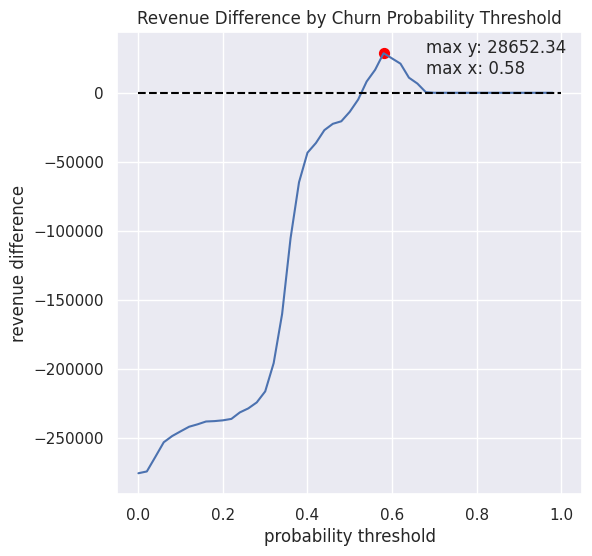

In [71]:
revenue_diffs = pd.Series({p: revenue_diff(p) for p in np.arange(0, 1, 0.02)})
plot_diff(revenue_diffs)
max_pred = revenue_diffs.idxmax()
max_diff = revenue_diffs.loc[max_pred]

In [72]:
max_revenue_discount = revenue_diff(max_pred)
increase_percentage = max_diff / raw_df['revenue_no_discount'].sum()
print(increase_percentage*100)

1.1633811506197793


We can clearly see that, using our model, with the right churn probability threshold, we can increase the total revenue by roughly 1.17 %.  
This result is based on many assumptions, for example, we assume that anyone given the discount isn't going to churn, and will eventually use this discount. We also assume that given that the client's consumption will remain the same even after getting a discount, which could not be the case in practice.  
If we want to improve this strategy even further, we can select the clients worth of the discount based on their profitability in addition to the churn probability. For example, we don't give the discount unless we know for sure that the revenue from that particular client will be higher than a certain threshold, thus saving us the pain of worrying about customers that are not profitable.

---

## Conclusion

Finally, we saw that our model, eventhough trained on incomplete data with very limited predictive power, was able to actually make an impact on the business, based on the assumption that we were given.  
For further investigations, we can also conduct an analysis on how to best select the discount (we don't know if the 20% discount is the most optimal for maximizing the revenue).  
I have personally learned a lot from this project, especially on how to make machine learning models talk and interact with the business, and I hope you had fun following along with me throughout this interesting story.